In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from implicit.als import AlternatingLeastSquares

In [11]:
# STEP 1A: LOAD YAHOO & COAT DATASET


def load_yahoo_data():
    """
    Load Yahoo! R3 dataset from predefined train, validation, and test files.
    """

    train = pd.read_csv("./yahoo/trainset.csv")
    valid = pd.read_csv("./yahoo/validset.csv")
    test = pd.read_csv("./yahoo/testset.csv")
    train = train[['user_id', 'item_id', 'rating']]
    valid = valid[['user_id', 'item_id', 'rating']]
    test = test[['user_id', 'item_id', 'rating']]

    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


def load_coat_data():
    """
    Load Coat dataset from predefined train, validation, and test files.
    """
    train = pd.read_csv("./coat/trainset.csv")
    valid = pd.read_csv("./coat/validset.csv")
    test = pd.read_csv("./coat/testset.csv")
    train.columns = valid.columns = test.columns = ['user_id', 'item_id', 'rating']
    return train, valid, test


In [12]:
# STEP 1B: SYNTHETIC DATASET GENERATION

def generate_synthetic_data(num_users=100, num_items=50, num_ratings=500):
    user_ids = np.random.randint(1, num_users + 1, num_ratings)
    item_ids = np.random.randint(1, num_items + 1, num_ratings)
    ratings = np.random.randint(1, 6, num_ratings)
    return pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': ratings})

In [13]:
# STEP 2: PROPENSITY SCORE COMPUTATION

def compute_propensities(df):
    item_popularity = df['item_id'].value_counts(normalize=True)
    rating_distribution = df['rating'].value_counts(normalize=True)
    df['popularity_propensity'] = df['item_id'].map(lambda x: item_popularity.get(x, 0.01))
    df['positivity_propensity'] = df['rating'].map(lambda x: rating_distribution.get(x, 0.01))
    df['multifactorial_propensity'] = df['popularity_propensity'] * df['positivity_propensity']
    df['ips_weight'] = 1 / (df['multifactorial_propensity'] + 1e-6)
    df['weighted_rating'] = df['rating'] * df['ips_weight']
    return df

In [14]:
# STEP 3A: MATRIX FACTORIZATION WITH SVD & ALS

def baseline_recommender(train, test):
    item_means = train.groupby('item_id')['rating'].mean()
    return test['item_id'].map(lambda x: item_means.get(x, 3))

def svd_recommender(train, test, k=20, debias=False):
    column = 'weighted_rating' if debias else 'rating'
    user_means = train.groupby('user_id')[column].mean()
    train['rating_normalized'] = train.apply(lambda x: x[column] - user_means.get(x['user_id'], 3), axis=1)
    user_item_matrix = train.pivot_table(index='user_id', columns='item_id', values=column, aggfunc='mean', fill_value=0)
    sparse_matrix = csr_matrix(user_item_matrix)
    U, sigma, Vt = svds(sparse_matrix, k=k)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
    predictions = []
    num_users, num_items = predicted_ratings.shape
    
    for _, row in test.iterrows():
        user_idx = min(max(int(row['user_id']) - 1, 0), num_users - 1)
        item_idx = min(max(int(row['item_id']) - 1, 0), num_items - 1)
        predictions.append(predicted_ratings[user_idx, item_idx])
    
    return np.clip(predictions, 1, 5)

def als_recommender(train, test, factors=20, debias=False):
    column = 'weighted_rating' if debias else 'rating'
    user_item_matrix = csr_matrix(train.pivot_table(index='user_id', columns='item_id', values=column, aggfunc='mean', fill_value=0))
    model = AlternatingLeastSquares(factors=factors, iterations=20)
    model.fit(user_item_matrix)
    
    predictions = []
    num_users, num_items = user_item_matrix.shape
    
    for _, row in test.iterrows():
        user_idx = min(max(int(row['user_id']) - 1, 0), num_users - 1)
        item_idx = min(max(int(row['item_id']) - 1, 0), num_items - 1)
        predictions.append(model.user_factors[user_idx] @ model.item_factors[item_idx].T)
    
    return np.clip(predictions, 1, 5)

In [15]:
# Neural Collaborative Filtering (NCF)
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=20):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, 1)

    def forward(self, user_ids, item_ids):
        user_emb = self.user_embedding(user_ids)
        item_emb = self.item_embedding(item_ids)
        x = torch.cat([user_emb, item_emb], dim=-1)
        return self.fc(x).squeeze()


def train_ncf(train, valid, num_epochs=10, embedding_dim=20):
    num_users = int(train['user_id'].max()) + 1
    num_items = int(train['item_id'].max()) + 1
    model = NCF(num_users, num_items, embedding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_users = torch.tensor(train['user_id'].values, dtype=torch.long)
    train_items = torch.tensor(train['item_id'].values, dtype=torch.long)
    train_ratings = torch.tensor(train['rating'].values, dtype=torch.float)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(train_users, train_items)
        loss = criterion(predictions, train_ratings)
        loss.backward()
        optimizer.step()
        
    return model

In [16]:
# STEP 4: EVALUATION

def evaluate(test, predictions):
    mse = mean_squared_error(test['rating'], predictions)
    mae = mean_absolute_error(test['rating'], predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test['rating'], predictions)
    return mse, mae, rmse, r2


In [26]:
from itertools import product

def grid_search(train, valid, test):
    param_grid = {
        "svd_k": [10, 20, 50],
        "als_factors": [10, 20, 50]
    }

    results = []
    
    for svd_k, als_factors in product(param_grid["svd_k"], param_grid["als_factors"]):
        svd_predictions = svd_recommender(train, valid, k=svd_k)
        svd_mse, _, _, _ = evaluate(valid, svd_predictions)
        
        als_predictions = als_recommender(train, valid, factors=als_factors)
        als_mse, _, _, _ = evaluate(valid, als_predictions)
        
        results.append({
            "svd_k": svd_k,
            "als_factors": als_factors,
            "svd_mse": svd_mse,
            "als_mse": als_mse
        })
    
    best_svd = min(results, key=lambda x: x["svd_mse"])
    best_als = min(results, key=lambda x: x["als_mse"])
    
    print("Best SVD Params:", best_svd)
    print("Best ALS Params:", best_als)
    
    return best_svd, best_als



Running Yahoo Dataset Experiment:


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Best SVD Params: {'svd_k': 20, 'als_factors': 10, 'svd_mse': 6.0605059502886, 'als_mse': 6.070630559963064}
Best ALS Params: {'svd_k': 20, 'als_factors': 20, 'svd_mse': 6.0605059502886, 'als_mse': 6.070538293588418}
Best SVD: {'svd_k': 20, 'als_factors': 10, 'svd_mse': 6.0605059502886, 'als_mse': 6.070630559963064}, Best ALS: {'svd_k': 20, 'als_factors': 20, 'svd_mse': 6.0605059502886, 'als_mse': 6.070538293588418}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Without Bias Correction:
SVD -> MSE: 1.7946, MAE: 0.8217, RMSE: 1.3396, R2: -0.6062
ALS -> MSE: 1.7872, MAE: 0.8186, RMSE: 1.3369, R2: -0.5996

With Bias Correction:
SVD -> MSE: 9.0162, MAE: 2.6321, RMSE: 3.0027, R2: -7.0697
ALS -> MSE: 1.7786, MAE: 0.8187, RMSE: 1.3337, R2: -0.5919


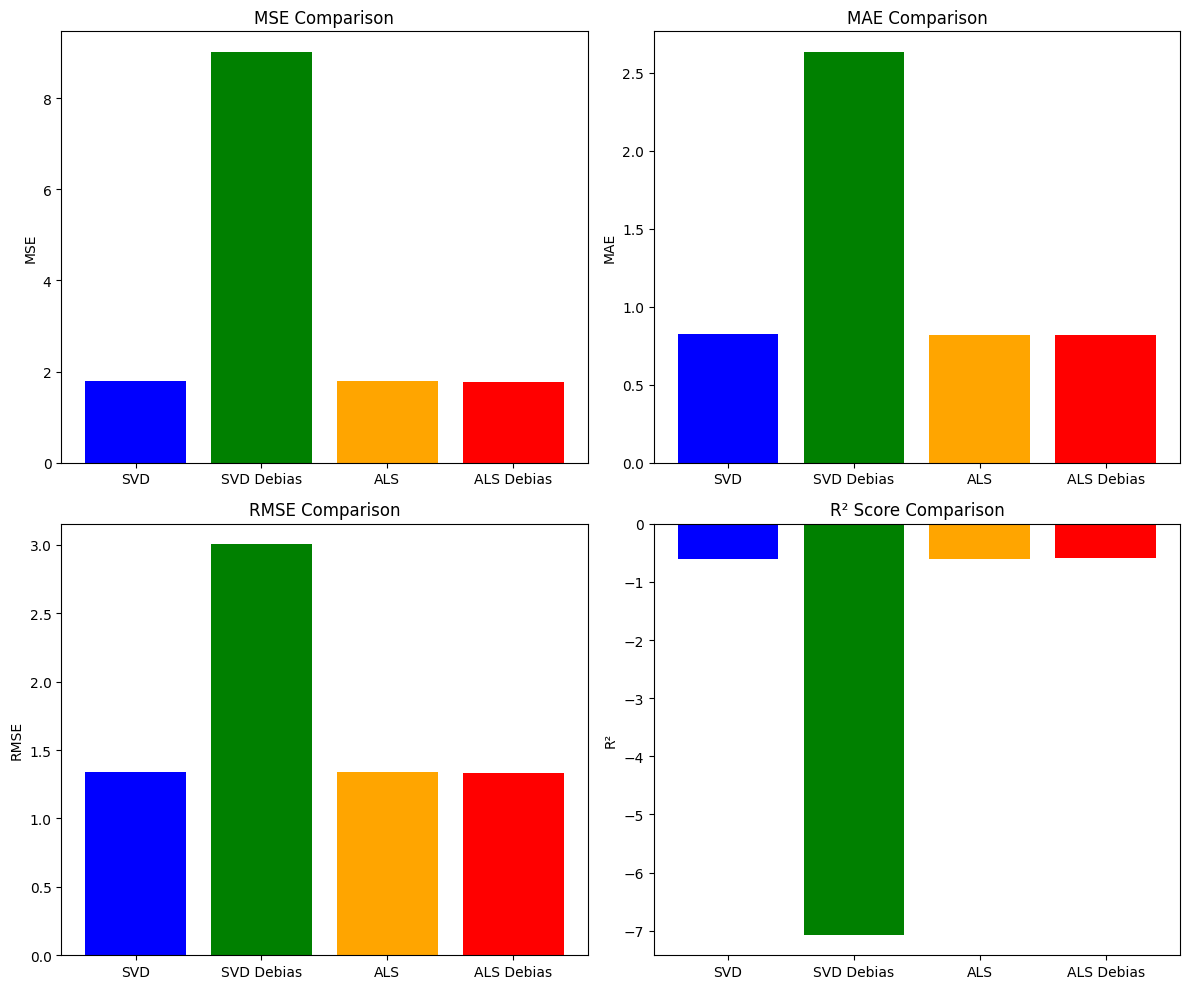


Running Coat Dataset Experiment:


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Best SVD Params: {'svd_k': 50, 'als_factors': 10, 'svd_mse': 4.072027677902212, 'als_mse': 4.301268020473626}
Best ALS Params: {'svd_k': 20, 'als_factors': 20, 'svd_mse': 4.1271840359357705, 'als_mse': 4.300483117936241}
Best SVD: {'svd_k': 50, 'als_factors': 10, 'svd_mse': 4.072027677902212, 'als_mse': 4.301268020473626}, Best ALS: {'svd_k': 20, 'als_factors': 20, 'svd_mse': 4.1271840359357705, 'als_mse': 4.300483117936241}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Without Bias Correction:
SVD -> MSE: 3.0552, MAE: 1.2349, RMSE: 1.7479, R2: -0.9687
ALS -> MSE: 3.0808, MAE: 1.2365, RMSE: 1.7552, R2: -0.9852

With Bias Correction:
SVD -> MSE: 6.6916, MAE: 2.1403, RMSE: 2.5868, R2: -3.3118
ALS -> MSE: 3.0684, MAE: 1.2351, RMSE: 1.7517, R2: -0.9772


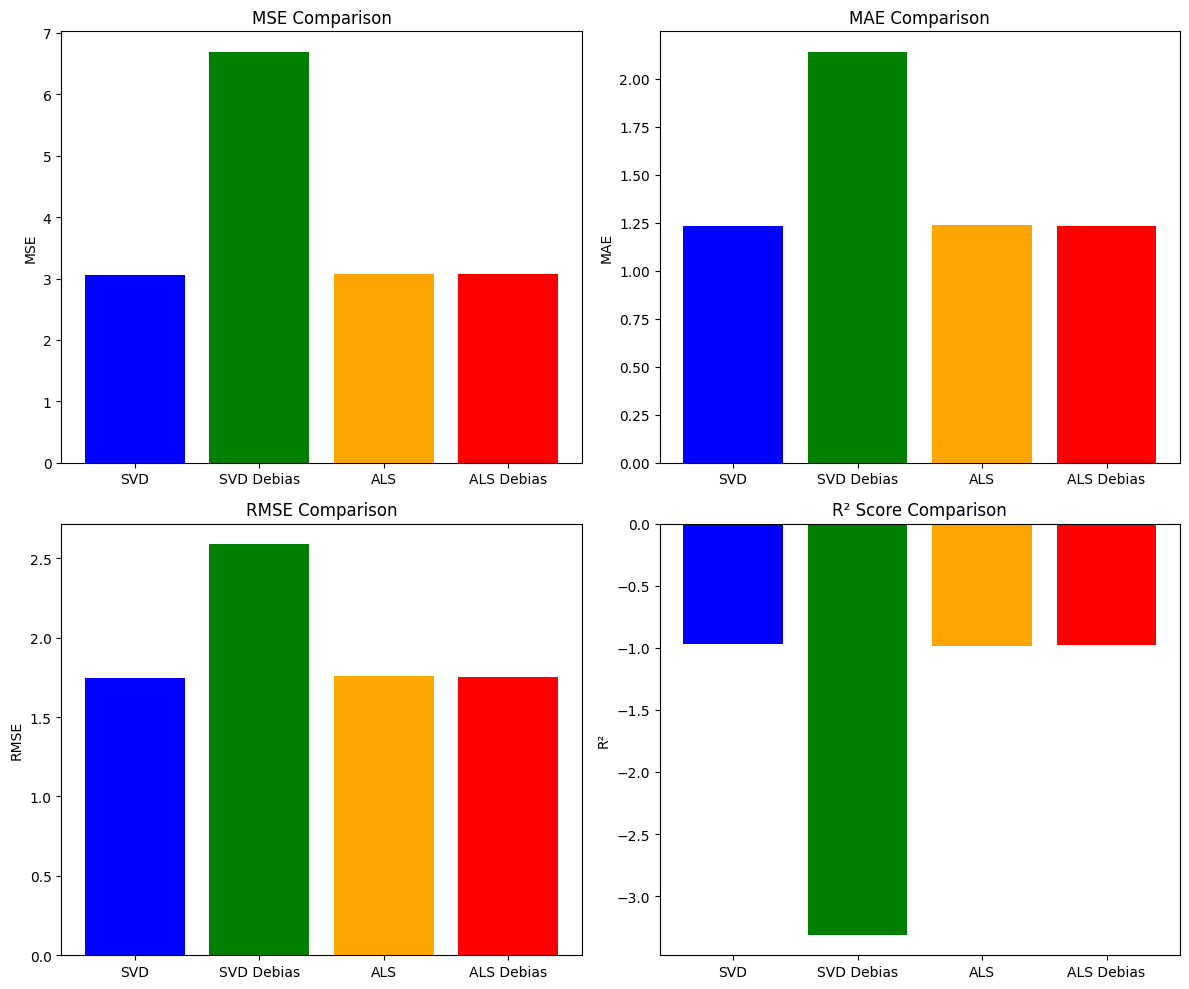


Running Synthetic Dataset Experiment:


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: `k` must be an integer satisfying `0 < k < min(A.shape)`.

In [30]:
def run_experiment(dataset='yahoo', use_synthetic=False):
    # Load dataset
    if use_synthetic:
        train = generate_synthetic_data()
        valid = generate_synthetic_data()
        test = generate_synthetic_data()
    elif dataset == 'yahoo':
        train, valid, test = load_yahoo_data()
    elif dataset == 'coat':
        train, valid, test = load_coat_data()
    
    # Compute propensities
    train = compute_propensities(train)
    valid = compute_propensities(valid)
    test = compute_propensities(test)
    
    # Find best hyperparameters using validation set
    best_svd, best_als = grid_search(train, valid, test)
    print(f"Best SVD: {best_svd}, Best ALS: {best_als}")

    # Evaluate models using best hyperparameters
    svd_predictions = svd_recommender(train, test, k=best_svd["svd_k"], debias=False)
    svd_debias_predictions = svd_recommender(train, test, k=best_svd["svd_k"], debias=True)
    als_predictions = als_recommender(train, test, factors=best_als["als_factors"], debias=False)
    als_debias_predictions = als_recommender(train, test, factors=best_als["als_factors"], debias=True)

    # Evaluate performance
    svd_metrics = evaluate(test, svd_predictions)
    svd_debias_metrics = evaluate(test, svd_debias_predictions)
    als_metrics = evaluate(test, als_predictions)
    als_debias_metrics = evaluate(test, als_debias_predictions)

    print("\nWithout Bias Correction:")
    print(f"SVD -> MSE: {svd_metrics[0]:.4f}, MAE: {svd_metrics[1]:.4f}, RMSE: {svd_metrics[2]:.4f}, R2: {svd_metrics[3]:.4f}")
    print(f"ALS -> MSE: {als_metrics[0]:.4f}, MAE: {als_metrics[1]:.4f}, RMSE: {als_metrics[2]:.4f}, R2: {als_metrics[3]:.4f}")

    print("\nWith Bias Correction:")
    print(f"SVD -> MSE: {svd_debias_metrics[0]:.4f}, MAE: {svd_debias_metrics[1]:.4f}, RMSE: {svd_debias_metrics[2]:.4f}, R2: {svd_debias_metrics[3]:.4f}")
    print(f"ALS -> MSE: {als_debias_metrics[0]:.4f}, MAE: {als_debias_metrics[1]:.4f}, RMSE: {als_debias_metrics[2]:.4f}, R2: {als_debias_metrics[3]:.4f}")

    # Plot comparisons
    labels = ['SVD', 'SVD Debias', 'ALS', 'ALS Debias']
    mse_values = [svd_metrics[0], svd_debias_metrics[0], als_metrics[0], als_debias_metrics[0]]
    mae_values = [svd_metrics[1], svd_debias_metrics[1], als_metrics[1], als_debias_metrics[1]]
    rmse_values = [svd_metrics[2], svd_debias_metrics[2], als_metrics[2], als_debias_metrics[2]]
    r2_values = [svd_metrics[3], svd_debias_metrics[3], als_metrics[3], als_debias_metrics[3]]

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    ax[0, 0].bar(labels, mse_values, color=['blue', 'green', 'orange', 'red'])
    ax[0, 0].set_title("MSE Comparison")
    ax[0, 0].set_ylabel("MSE")

    ax[0, 1].bar(labels, mae_values, color=['blue', 'green', 'orange', 'red'])
    ax[0, 1].set_title("MAE Comparison")
    ax[0, 1].set_ylabel("MAE")

    ax[1, 0].bar(labels, rmse_values, color=['blue', 'green', 'orange', 'red'])
    ax[1, 0].set_title("RMSE Comparison")
    ax[1, 0].set_ylabel("RMSE")

    ax[1, 1].bar(labels, r2_values, color=['blue', 'green', 'orange', 'red'])
    ax[1, 1].set_title("R² Score Comparison")
    ax[1, 1].set_ylabel("R²")

    plt.tight_layout()
    plt.show()


# Run experiments on different datasets
if __name__ == "__main__":
    print("\nRunning Yahoo Dataset Experiment:")
    run_experiment(dataset='yahoo', use_synthetic=False)
    
    print("\nRunning Coat Dataset Experiment:")
    run_experiment(dataset='coat', use_synthetic=False)
    
    print("\nRunning Synthetic Dataset Experiment:")
    run_experiment(dataset='', use_synthetic=True)

In [18]:
def evaluate_ncf(model, test):
    model.eval()
    test_users = torch.tensor(test['user_id'].values, dtype=torch.long)
    test_items = torch.tensor(test['item_id'].values, dtype=torch.long)
    with torch.no_grad():
        predictions = model(test_users, test_items).numpy()
    return predictions

def run_experiment(dataset='yahoo', use_synthetic=False):
    if use_synthetic:
        train = generate_synthetic_data()
        valid = generate_synthetic_data()
        test = generate_synthetic_data()
    elif dataset == 'yahoo':
        train, valid, test = load_yahoo_data()
    elif dataset == 'coat':
        train, valid, test = load_coat_data()
    
    train = compute_propensities(train)
    valid = compute_propensities(valid)
    test = compute_propensities(test)
    
    best_k = 20
    
    ncf_model = train_ncf(train, valid)
    ncf_predictions = evaluate_ncf(ncf_model, test)
    
    print("Neural Collaborative Filtering (NCF):")
    print(evaluate(test, ncf_predictions))
    
if __name__ == "__main__":
    run_experiment(dataset='yahoo', use_synthetic=False)


Neural Collaborative Filtering (NCF):
(4.8175506591796875, 1.8596620559692383, np.float64(2.1948919470396913), -3.311800479888916)
